$\textbf{Logistic Regression}$

Basic Model: $Y \sim Bern(\phi(XB))$, where $\phi$ is the logistic function 


In [186]:
set.seed(1)
x=runif(1000)*10-5 #distribution of x is irrelevant
y=rbinom(1000, 1, plogis(3*x-2)) #this is how the model assumes y is generated
df=data.frame('x'=x,'y'=y)

$\textbf{Assumptions:}$ 

that the $y_i$ are independent and each was drawn from bernoulli distribution, with probability parameter defined by $\phi(x_iB)$. These are the only formal assumptions. However, they imply certain things. For instance, this formulation is equivalent to $E(Y)=\phi(XB)$, which is equivalent to $\phi^{-1}(E(Y))=XB$. (Note also that this implies that $Var(Y)=\phi(XB)(1-\phi(XB))$ but this is not particularly useful). I won't derive this, but it can also be shown that this formulation is equivalent to a hidden variable model with standard logistic distributed residuals. However, since that model is a hidden variable model we can't check the residuals because we can't actually see them.

Footnote: Technically the only formal assumption for gaussian linear regression are $Y \sim N(XB, \sigma^2)$, but this immediately implies $Y \sim XB+N(0,\sigma^2)$, where the last term is rightly called "error", thus giving us the error assumption.

Footnote: why do we use log odds as our link function? It is because we need to map from $\mathbb{R}$ to $(0,1)$, and we do this in two steps. Let's approach the problem backwards and then find the inverse: $(0,1)$ to $\mathbb{R}$. To do this, first we realize the $x/(1-x)$ will map $(0,1)$ to $(0, \infty)$. Next, log will map $(0, \infty)$ to $(-\infty, \infty)$. Thus we have $log(x/(1-x))$ as our function. Howeover remember that this is the inverse of what we really want, so with algebra we get $\phi(x)=e^x/(e^x+1)$, which is called the logistic function, and thus $log(x/(1-x))$ is the called inverse logistic function (or logit). Now, regarding mapping, if we are a little creative we can realize that the Normal CDF ($\Phi(x) = \frac 1 {\sqrt{2\pi}} \int_{-\infty}^x e^{-t^2/2} \, {\rm d}t$) maps values from $(0,1)$ to $\mathbb{R}$, and hence we could let $\phi$ be the inverse of the normal cdf.




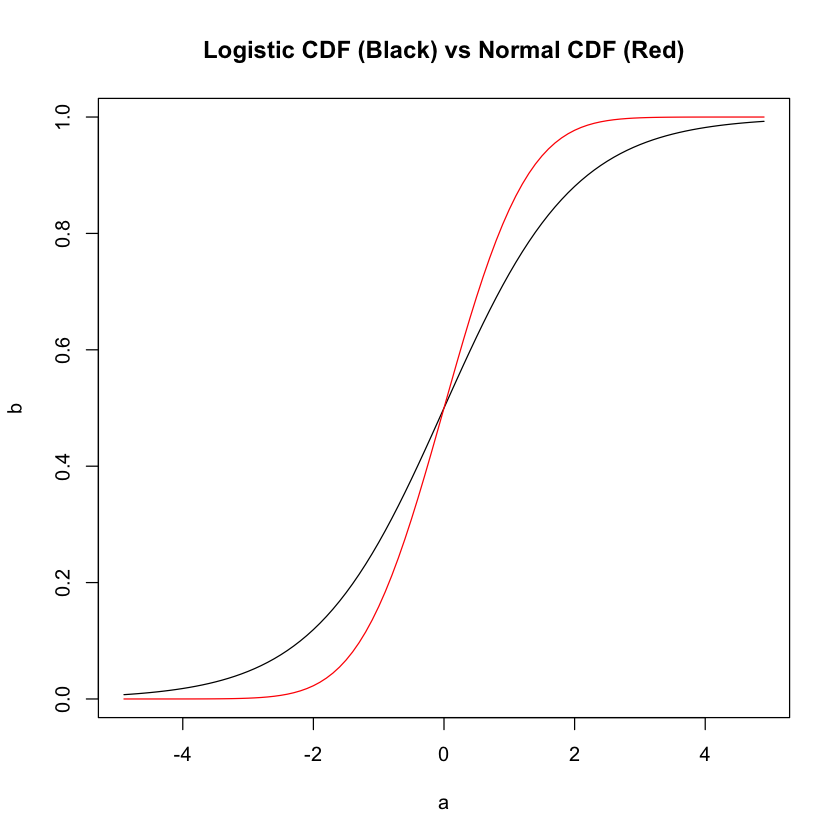

In [187]:
a=((1:99)/100)*10-5
b=plogis(a)
plot(b~a, pch=16, type="n",main="Logistic CDF (Black) vs Normal CDF (Red)")
lines(b~a)

c=pnorm(a)
lines(c~a, col="red")

$\textbf{Fitting the model:}$ 

Find paramter values that maximize the likelihood function: what values of the coefficients make the y's most likely given the x's.

$$\begin{align}
L(\theta | X) &= Pr(Y | X; \theta) \\
  &= \prod_i Pr(y_i | x_i; \theta) \\
  &= \prod_i \phi(x_iB)^{y_i}(1 - \phi(x_iB))^{(1-y_i)}
\end{align}$$
Typically the -log of the liklihood is mimimized. In any case, there is no closed form solution.
That said, because we have the log likelihood is convex numerous algorithms exist which can reliably find the minimum.


In [188]:
m=glm(y~x, data=df, family="binomial") #fit the model
summary(m) #summary


Call:
glm(formula = y ~ x, family = "binomial", data = df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.86712  -0.05628  -0.00136   0.03263   2.87110  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.7733     0.2308  -7.684 1.54e-14 ***
x             2.8389     0.2581  10.997  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1364.3  on 999  degrees of freedom
Residual deviance:  213.4  on 998  degrees of freedom
AIC: 217.4

Number of Fisher Scoring iterations: 8


$\textbf{Interpretation:}$
1. Because our estimators for the coefficients are MLEs they are assympotitically normal, therefore we can nicely conduct inference on them (not that they do not follow a t-distribution). 
2. Just as a slope coefficient in OLS was the expected change in y given a unit increase in x, it is now repesents the change in log odds of y, or in other words it is the ratio of the odds of y given x and x+1. Similarly, just as the intercept was the expected value of y given x=0, now it is the log odds of y given x=0.
3. Deviance, which is just 2(log_likelihood_full_model-log_likelihood_reduced_model), can be used to test the hypothesis that a model is a better fit than a nested model, in the same way that sum of squared residuals is used for ordinary regression (in fact, the sum of squares is actually the deviance of the gaussian model) 
4. Importantly, because we use a linear model and our estimates of the coefficients are assymptotically unbiased our estimate of log odds is unbiased, however, our estimate of probability is NOT unbiased. - however, in practice this may not be an issue, and we are still producing a "consistent" estimator of p.

These points are demonstrated below:

In [79]:
#1
confint.default(m)

,2.5 %,97.5 %
(Intercept),-2.225603,-1.320956
x,2.332942,3.344863


In [189]:
int=rep(0,1000)
slope=rep(0,1000)
for(i in 1:1000){
    x=runif(1000) #distribution of x is irrelevant
    y=rbinom(1000, 1, plogis(3*x-2)) #this is how the model assumes y is generated
    df=data.frame('x'=x,'y'=y)
    m=glm(y~x, data=df, family="binomial") #fit the model
    ci=confint.default(m)
    if(ci[1,1]<=-2 & ci[1,2]>=-2){
        int[i]=1
    }
    if(ci[2,1]<=3 & ci[2,2]>=3){
        slope[i]=1
    }
}
c(mean(int), mean(slope))

[1] 0.954 0.953

2)

$logit(E(y)|x=0)=b_0+b_1(0)=b_0$

and letting

$$l_0:=log(odds(E(y)|x))=b_0+b_1x$$
$$l_1:=log(odds(E(y)|x+1))=b_0+b_1(x+1)$$
we can see
$$l_1-l_0=b_1$$
$$log(odds(E(y)|x+1)/odds(E(y)|x))=b_1$$




In [190]:
#Deviance
x=runif(1000) #distribution of x is irrelevant
x1=runif(1000)
y=rbinom(1000, 1, plogis(3*x-2)) #this is how the model assumes y is generated
df=data.frame('x'=x,'x1'=x1,'y'=y)
m2=glm(y~x+x1, data=df, family="binomial")
m1=glm(y~x, data=df, family="binomial")
anova(m2,m1, test = "Chisq") #compare the model with both variables to the model with only x, conclude x1 is not relevant
m0=glm(y~1, data=df, family="binomial")
anova(m1,m0, test = "Chisq") #compare a model with only intercept to model with x, conclude x is relevant


Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
997,1186.75,NA,NA,NA
998,1187.58,-1,-0.8301902,0.3622176


Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
998,1187.580,NA,NA,NA
999,1359.934,-1,-172.3541,2.264785e-39


Bias


Call:
lm(formula = expected_prob ~ actual_prob)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27685 -0.04107  0.01401  0.06002  0.18005 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.01547    0.03921   0.394    0.697    
actual_prob  0.91366    0.05929  15.411 6.38e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1039 on 21 degrees of freedom
  (26 observations deleted due to missingness)
Multiple R-squared:  0.9188,	Adjusted R-squared:  0.9149 
F-statistic: 237.5 on 1 and 21 DF,  p-value: 6.382e-13


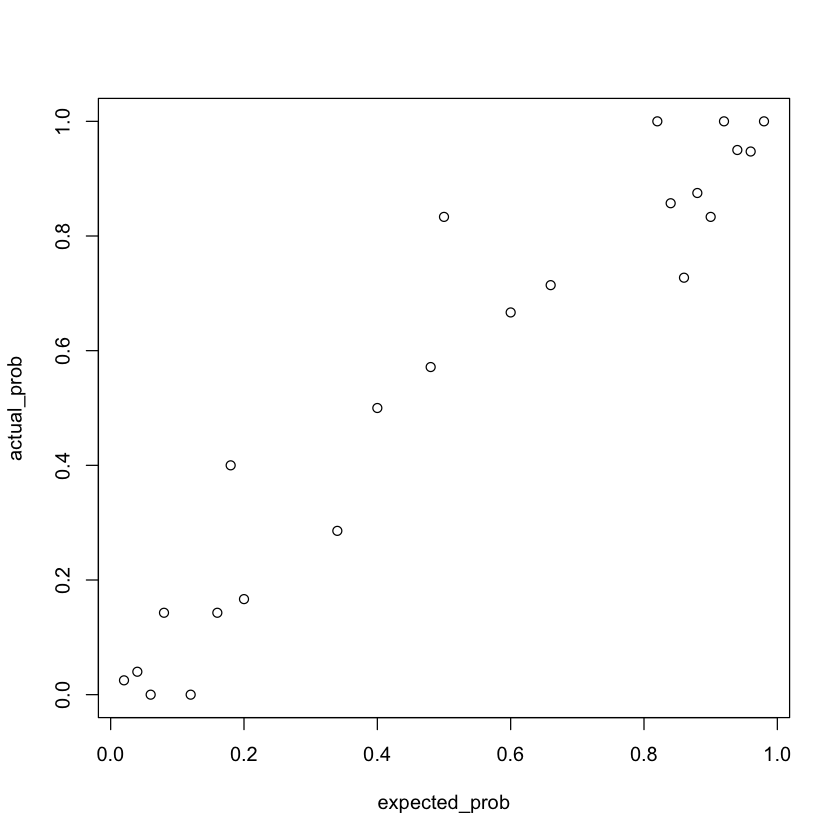

In [191]:
set.seed(98)
x=runif(1000)*10-5 #distribution of x is irrelevant
y=rbinom(1000, 1, plogis(x)) #this is how the model assumes y is generated
df=data.frame('x'=x,'y'=y)
m=glm(y~x, data=df, family="binomial") #fit the model
preds=predict(m,df, type="response")
expected_prob=(1:49)/50
actual_prob=sapply(expected_prob, function(i) {
    if(sum(preds>(i-.01) & preds<i)>5){return(mean(df$y[preds>(i-.01) & preds<i ]))}
    else{return(NA)}
    })
plot(actual_prob~expected_prob)
summary(lm(expected_prob~actual_prob))



Call:
lm(formula = actual_prob ~ expected_prob)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0138934 -0.0034708  0.0003537  0.0037674  0.0119360 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.03374    0.05957   0.566    0.584    
expected_prob  0.96002    0.06367  15.078 3.33e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007614 on 10 degrees of freedom
  (87 observations deleted due to missingness)
Multiple R-squared:  0.9579,	Adjusted R-squared:  0.9537 
F-statistic: 227.3 on 1 and 10 DF,  p-value: 3.326e-08


[1] 0.98686

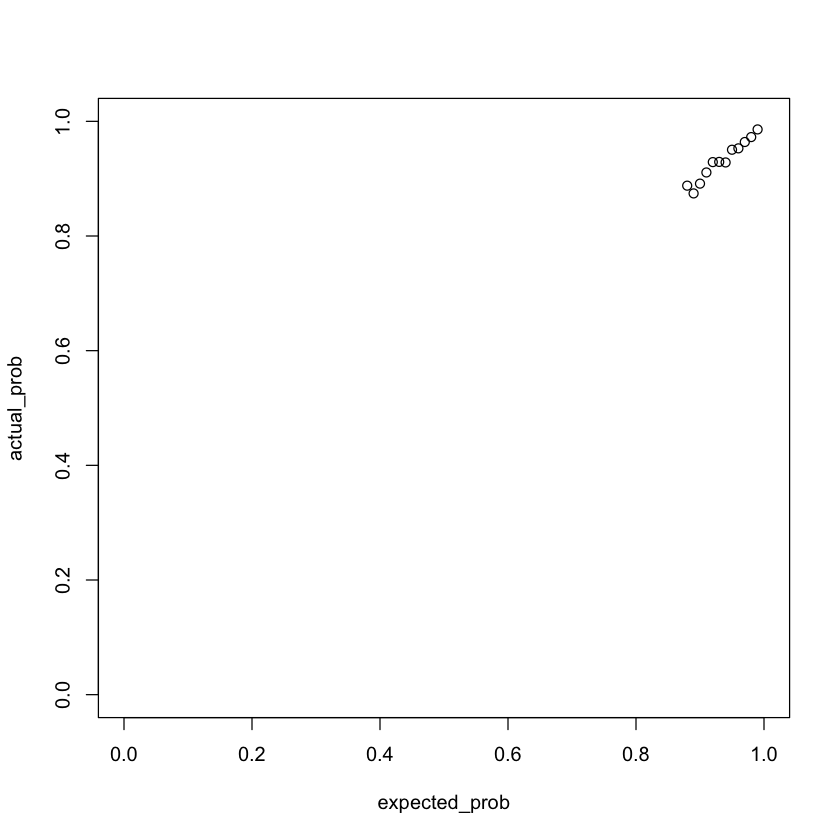

In [2]:
x=runif(100000)*10+2 #distribution of x is irrelevant
y=rbinom(100000, 1, plogis(x)) #this is how the model assumes y is generated
df=data.frame('x'=x,'y'=y)
m=glm(y~x, data=df, family="binomial") #fit the model
preds=predict(m,df, type="response")
expected_prob=(1:99)/100
actual_prob=sapply(expected_prob, function(i) mean(df$y[preds>(i-.01) & preds<i ]))
plot(actual_prob~expected_prob, ylim=c(0,1), xlim=c(0,1))
summary(lm(actual_prob~expected_prob))
mean(y)

$\textbf{Important Points:}$

1. Coefficients are only valid in the context of the model.
2. Significance of coefficient is different from model fit (even if none of the coefficients are significant then).
3. At the same time, testing the model against a model reduced by one variable is equivalent to the significance of that variable IN THE CURRENT MODEL.
4. Correlation between coefficients does not particularly degrade model fit, however, it explodes the error in our coefficent estimates

In [193]:
set.seed(2)
x=runif(1000) #distribution of x is irrelevant
x1=-x+runif(1000)*.1
y=rbinom(1000, 1, plogis(3*x-2)) #this is how the model assumes y is generated
df=data.frame('x'=x,'x1'=x1,'y'=y)
m2=glm(y~x+x1, data=df, family="binomial")
print(summary(m2))



Call:
glm(formula = y ~ x + x1, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6373  -0.9454  -0.6302   1.0399   1.9437  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.8258     0.1926  -9.478   <2e-16 ***
x             3.9683     2.3722   1.673   0.0944 .  
x1            1.2138     2.3522   0.516   0.6058    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1357.9  on 999  degrees of freedom
Residual deviance: 1216.5  on 997  degrees of freedom
AIC: 1222.5

Number of Fisher Scoring iterations: 4



In [5]:
set.seed(1)
x=runif(1000) #distribution of x is irrelevant
x1=-x+runif(1000)*.1
y=rbinom(1000, 1, plogis(3*x-x1-2)) #this is how the model assumes y is generated
df=data.frame('x'=x,'x1'=x1,'y'=y)
m2=glm(y~x+x1, data=df, family="binomial")
print(summary(m2))
m1=glm(y~x1, data=df, family="binomial")
print(summary(m1))
anova(m2,m1, test = "Chisq") #compare the model with both variables to the model with only x, conclude x1 is not relevant
m1a=glm(y~x, data=df, family="binomial")
anova(m2,m1a, test = "Chisq") #compare a model with only intercept to model with x, conclude x is relevant
m0=glm(y~1, data=df, family="binomial")
anova(m2,m0, test = "Chisq") #compare a model with only intercept to model with x, conclude x is relevant



Call:
glm(formula = y ~ x + x1, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1039  -0.8631  -0.4606   0.8577   2.1334  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.0257     0.2027  -9.994   <2e-16 ***
x             0.9814     2.4933   0.394    0.694    
x1           -3.3242     2.4851  -1.338    0.181    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1386.0  on 999  degrees of freedom
Residual deviance: 1098.1  on 997  degrees of freedom
AIC: 1104.1

Number of Fisher Scoring iterations: 3


Call:
glm(formula = y ~ x1, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1174  -0.8620  -0.4554   0.8573   2.1383  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.9731     0.1518  -13.00   <2e-16 ***
x1         

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
997,1098.111,NA,NA,NA
998,1098.266,-1,-0.155044,0.693761


Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
997,1098.111,NA,NA,NA
998,1099.903,-1,-1.792548,0.180616


Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
997,1098.111,NA,NA,NA
999,1386.038,-2,-287.9277,3.001226e-63


$\textbf{More on interpretation:}$

Interpreting the model (everything is multiplicative, and interactions are technically exponential)


In [130]:
x=runif(1000)*3-1.5 #distribution of x is irrelevant
x1=runif(1000)*3-1.5
y=rbinom(1000, 1, plogis(3*x -x1-2)) #this is how the model assumes y is generated
df=data.frame('x'=x,'x1'=x1,'y'=y)
m=glm(y~x+x1, data=df, family="binomial")
print(summary(m))

base=predict(m,data.frame('x'=1,'x1'=1,'y'=0), type="link")
change=predict(m,data.frame('x'=2,'x1'=1,'y'=0), type="link")-base
base_prob=plogis(base)
new_prob=plogis(base+change)
base_odds=base_prob/(1-base_prob)
new_odds=new_prob/(1-new_prob)

print("log of odds ratio")
print(log(new_odds/base_odds))


Call:
glm(formula = y ~ x + x1, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3522  -0.4673  -0.1353   0.4512   2.7830  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.1528     0.1583 -13.602  < 2e-16 ***
x             3.0021     0.2001  15.006  < 2e-16 ***
x1           -0.8546     0.1250  -6.837 8.06e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1213.14  on 999  degrees of freedom
Residual deviance:  656.51  on 997  degrees of freedom
AIC: 662.51

Number of Fisher Scoring iterations: 6

[1] "log of odds ratio"
       1 
3.002123 


In [131]:
set.seed(1)
x=runif(1000)*3-1.5 #distribution of x is irrelevant
x1=runif(1000)*3-1.5
y=rbinom(1000, 1, plogis(3*x -x1  + x1^2 + x1*x -2)) #this is how the model assumes y is generated
df=data.frame('x'=x,'x1'=x1,'y'=y)
m=glm(y~x+x1+I(x1^2)+x1:x, data=df, family="binomial")
print(summary(m))
base=predict(m,data.frame('x'=1,'x1'=1,'y'=0), type="link")
change=predict(m,data.frame('x'=2,'x1'=1,'y'=0), type="link")-base
base_prob=plogis(base)
new_prob=plogis(base+change)
base_odds=base_prob/(1-base_prob)
new_odds=new_prob/(1-new_prob)

print("log of odds ratio")
log(new_odds/base_odds)

eq<-function(x,x1){3.1128*x -1.1611*x1  + 1.0787*x1^2 + 1.0607*x1*x -1.9964}
print("change in linear function value")
eq(2,1)-eq(1,1)


Call:
glm(formula = y ~ x + x1 + I(x1^2) + x1:x, family = "binomial", 
    data = df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.45524  -0.44967  -0.08005   0.49075   2.88649  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.9964     0.1883 -10.601  < 2e-16 ***
x             3.1128     0.2089  14.898  < 2e-16 ***
x1           -1.1611     0.1327  -8.751  < 2e-16 ***
I(x1^2)       1.0787     0.1595   6.762 1.36e-11 ***
x:x1          1.0607     0.2173   4.882 1.05e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1350.74  on 999  degrees of freedom
Residual deviance:  664.81  on 995  degrees of freedom
AIC: 674.81

Number of Fisher Scoring iterations: 6

[1] "log of odds ratio"


1 
4.173536

[1] "change in linear function value"


[1] 4.1735

If Data are linearly seperably then the ideal coefficient would be infinity, beause every predictor value beyond a certaint pt would be guaranteed to be 1, whereas less would be guaranteed to be 0.
In practice glm will still fit and give a warning. In such a case the results are still usable in industry, but not ideal.
Technically there is some work with using directions of recession to solve this problem and produce correct one sided confidence intervals for the coefficents.
Anyway, a simple way to solve this in practice is to use a penalty function.

Just like we can use ridge, lasso, or a million other penalties with linear regression, we can similarly tack them on on the logistic regression loss function and optimize away.
    
Seth already showed this, but one issue with using penalty functions is that it makes classical inference on the coefficients difficult. That said, it is possible to recast most (all?) penalties as priors and do bayesian analysis.
For instance, ridge penalty is equivalent to a $N(0,\sigma)$ prior on the coefficients, with the $\sigma$ being related to the value of the penalty parameter $\lambda$

In [15]:
set.seed(1)
x=runif(100)
y=x>.5
df=data.frame('x'=x,'y'=y)
m=glm(y~x, data=df, family="binomial")
print(summary(m))

print("LASSO:")
library(penalized)
p=penalized(y, x,lambda1=1, data=df, model="logistic")
#str(p)
p@penalized
p@unpenalized


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Call:
glm(formula = y ~ x, family = "binomial", data = df)

Deviance Residuals: 
       Min          1Q      Median          3Q         Max  
-1.989e-04  -2.100e-08  -2.100e-08   2.100e-08   1.846e-04  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -864.7   153635.6  -0.006    0.996
x             1701.8   302738.9   0.006    0.996

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1.3847e+02  on 99  degrees of freedom
Residual deviance: 7.3649e-08  on 98  degrees of freedom
AIC: 4

Number of Fisher Scoring iterations: 25

[1] "LASSO:"
# nonzero coefficients: 2          


13.52359

(Intercept) 
  -7.268789

$\textbf{What is a classifier?}$

A classifier outputs the predicted "class label" of an observation.

Logistic Regression as classifier:
1. Logistic regression does not do this, it gives the pobability that an observation is in class 1. However, logistic regression can immediately be used for classification if we choose a threshold. Typically, we would use $\hat{P}(y=1|x)>.5$ as the threshold for classification. Note that since $\hat{P}(y=1|x)=\phi(b_0+bx)$ this is equivalent to the condition that $b_0+bx=0$ 
2. This would be a great choose of threshold if the cost of false positives and false negatives was equal, but if there are not equal it is no longer optimal. Suppose that we owned a truck and wanted to predict whether it would crash while carrying a given load. Since the cost of the truck crashing is presumably far greater than the foregone profits if we decline a load, then we should probably decline loads for some threshold probability much lower than 0.5 

Assessing a classifier:
1. Accuracy (the percentage of correctly classified observations) is a naive way of assessing how good a classifier is, but it has huge limitations. One example would be the case where 99% of observations are "No Crash", and 1% are "Crash". In this case, simply classifying all observations as "No Crash" would give 99% accuracy. Suppose we had a model that correctly predicted all the crashes, as well as mispredicting that another 3% of observations would crash. This model would have an accuracy of 97%, yet would be far better, assuming the cost of the crash is very high.
2. If we can explicitly write the cost of false positives and false negatives this is called a loss function, and we can simply choose a model that minimizes the expected loss, or that minimizes the maximum loss. If we can write the loss function it seems sensible to use the loss function to choose the model and make decisions.
3. If we can't write the loss function, then we have other ways of accessing goodness as a classifier, such as ROC, AUC,PR curve, F1 score etc.

In [196]:
#Loss
set.seed(1)
x=runif(1000)*10-5 #distribution of x is irrelevant
y=rbinom(1000, 1, plogis(x)) #this is how the model assumes y is generated
df=data.frame('rain'=x,'crash'=y)
m=glm(y~x, data=df, family="binomial")
preds=predict(m,df,type="response")
cost_of_crash=100000
cost_of_declined_load=1000
loss=function(actual, pred){
    error=actual-pred
    return(sum((error>0)*cost_of_crash+(error<0)*cost_of_declined_load))
}
print("Dollars Lost using .5 as cutoff")
loss(df$crash,preds>.5)
print("Dollars Lost using .1 as cutoff")
loss(df$crash,preds>.1)
print("Dollars Lost using .01 as cutoff")
loss(df$crash,preds>.01)
print("Dollars Lost using 0 as cutoff")
loss(df$crash,preds>0)
print("Loads actually run using .01 cutoff")
sum(preds<.01)
print("Observed Crashes")
sum(y)



[1] "Dollars Lost using .5 as cutoff"


[1] 7862000

[1] "Dollars Lost using .1 as cutoff"


[1] 927000

[1] "Dollars Lost using .01 as cutoff"


[1] 432000

[1] "Dollars Lost using 0 as cutoff"


[1] 519000

[1] "Loads actually run using optimal cutoff"


[1] 87

[1] "Observed Crashes"


[1] 481

In the above scenario one could argue that minimizing the loss function is just dumb because it means that we barely take any business. But of course it seems more sensible to say that our high number of crashes is the real problem (we could also try to reduce the cost of a crash somehow, like by buying insurance, although presumably we would not find anyone that would insure us for a lower cost).



$\textbf{Basic Definitions:}$
1. TP= predict 1 and observe 1.
2. FP= predict 1 observe 0
3. FN= predict 0 observe 1
4. TN= predict 0 observe 0

5. Precision： P=TP/(TP+FP)
6. Recall： R=TP/(TP+FN)
7. F1-score： 2/(1/P+1/R)
8. ROC/AUC： TPR=TP/(TP+FN), FPR=FP/(FP+TN)

Comparing Models By AUC and ROC

ROC=Reciever Operating Characteristic

In a "null" model, the true positive rate and the false positive rate should be equal for any classification threshold.



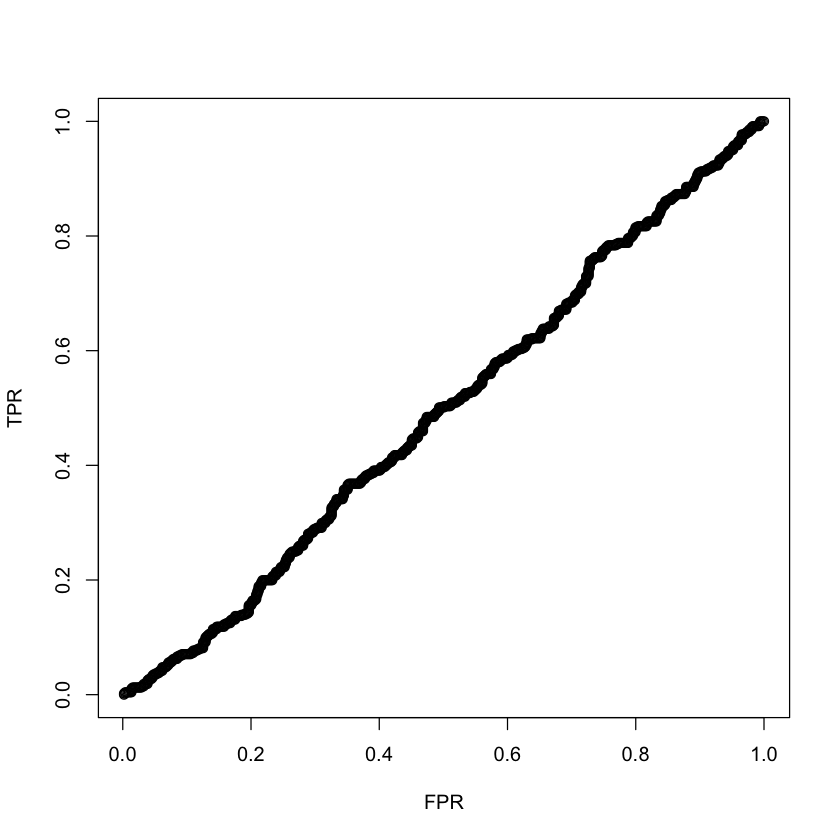

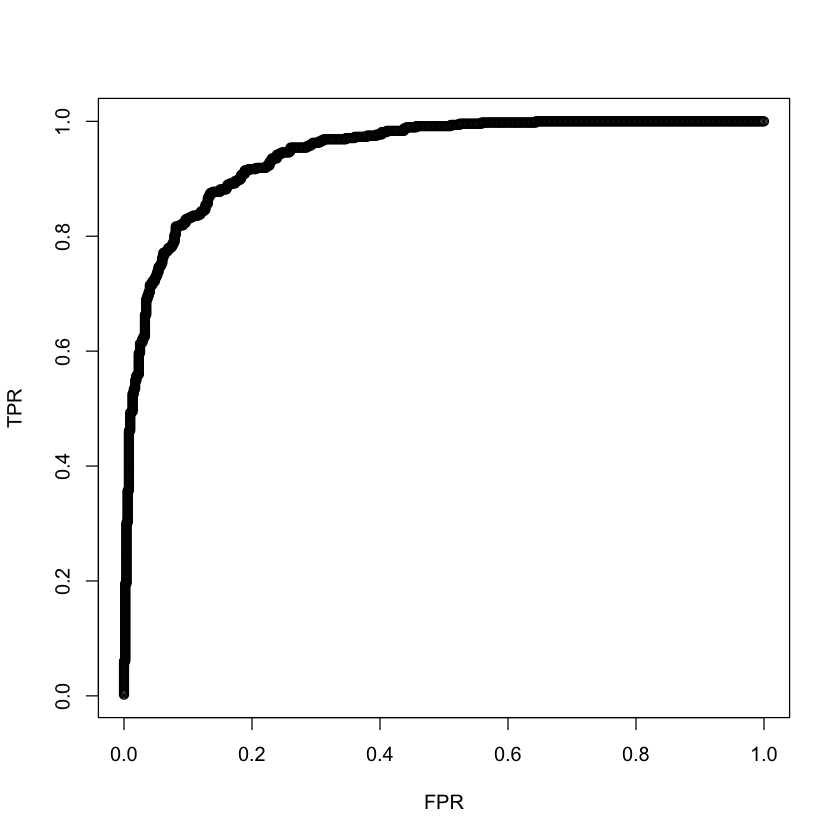

In [201]:
roc <- function(y, preds){
  y <- y[order(preds, decreasing=TRUE)]
  data.frame(TPR=cumsum(y)/sum(y), FPR=cumsum(!y)/sum(!y), y)
}
plot(TPR~FPR,simple_roc(df$crash, runif(1000)))#Null Model
plot(TPR~FPR,simple_roc(df$crash, preds)) #Our model is very good.


ROC gives us an idea for where we might want to set the threshold, and it gives us an idea of how good a model is, but how can we quantitatively compare two models?

AUC=Area Under Curve
Idea: The better the ROC curve the higher the TPR gets before the FPR increases. This means that the better the ROC curve, the greater the area under it. So we can imagine that a model that is purely random, having a straight line ROC, would have an AUC of .5, whereas a perfect model attaining an TPR of 1 while maintaining a FPR of 0 would have AUC of 1.



HOWEVER, ROC/AUC is not a "proper" accuracy scoring rule- it is not necessarily optimized by a correct model.
Log-likelihood, and the Bayesian DIC are.

Moreover, it is easy to find criticism of this method in academic papers, including
1. it weights FP and FN equally, which is often undesirable
2. by providing a "global" summary of performance it includes areas where we would not operate
3. etc.




$\textbf{Gaussian Discriminant Analysis}$

Now, our model is 
$$x|y \sim N(\mu_y, \Sigma_y)$$


Note that this is completely different in theory from logistic regression- in logistic regression our Weltanschauung is that the predictors determine the probability of the outcome: your environment and how you were raised, determine your propensity to become a criminal. (Discriminative Classifier)


In Gaussian discriminant analysis, we flip this on its head, and consider the situation where the class determines the distribution of the covariates: the species of an animal determines the distribution of its weight, shoulder height, tail length etc. (Generative Classifier)


Now, in practice, either method can be used for classification, but it is important to note that the assumption of GDA is arguably much stronger than the assumptions of Logistic Regression, since in Logistic Regression we are only making a distributional assumption about the response and estimating predictor number of parameters, whereas in GDA we impose a joint distributional assumption on all of the predictors and estimate at least 3 times the number of predictors.

Thus, we can hypothesize that logistic regression will perform better than GDA in general, but that GDA will outperform logistic regression when its assumptions are true or close to true.

$\textbf{Basic idea behind use as classifier:}$
$$P(Y=y|X)= \frac{P(X|Y=y)P(Y=y)}{\sum_y{P(X|Y=y)P(Y=y)}}$$ 
Note classification would just be done by choosing the class label with the highest probability, and then denominator is constant, so therefore we can remove that denominator and simply assign the class label for which the value
$$\frac{P(X|Y=y)P(Y=y)}{\sum_y{P(X|Y=y)P(Y=y)}}$$ 
is highest.
Now, according to our model, $P(X|Y=y)$ follows $N(\mu_y, \Sigma_y)$, so we need to estimate $mu_y$ and $\Sigma_y$, which we simply estimate empirically as the mean and covariance of the training data. Similarly, we simply estimate P(Y=y) from the observed class proportions.


$\textbf{Variations:}$

1) Naive Bayes: 

If we assume that the $\Sigma$ for each class is different but only diagonal (i.e. covariances are all 0, which, in the case of MVN distribution implies independence) this is called Naive Bayes (it is bayesian, and the assumption of independence is "naive"?)


2) Linear Discriminant analysis:

If we assume that $\Sigma$ is the same for all classes the classification boundaries become linear, hence "Linear Discrimant Analysis"

3) Quadratic Discriminant analysis:

If we assume that $\Sigma$ is different for all classes the classification boundaries become quadratic, hence "Quadratic Discrimant Analysis"

4) Regularized Discriminant analysis:

If we estimate both a common $\Sigma$ and individual $\Sigma$'s and then use $\lambda\Sigma+(1-\lambda)\Sigma_y$ as the covariance matrix for each class, then we have effectively shrunk the class specific parameters towards the overall parameter estimate, hence "regularization." Why is this useful??? Because when the amount of data does not support a good estimate of all the parameters in the model then we can get better performance by reducing the effective number of parameters to an "ideal" level.

5) Additional variations:

We could shrink only the covariances towards a global coaviarnce, or we could shrink them towards 0 (i.e. $\lambda \text{diag}(\Sigma_y)+(1-\lambda)\Sigma_y$). In general, people write lots of papers about this because any of these methods could be the best method if the data actually were generated from that method.




[1] -0.6748565

[1] -0.6748565

[1] 0.9747

           x1         x2
x1  2.4873282 -0.0608057
x2 -0.0608057  1.2718134


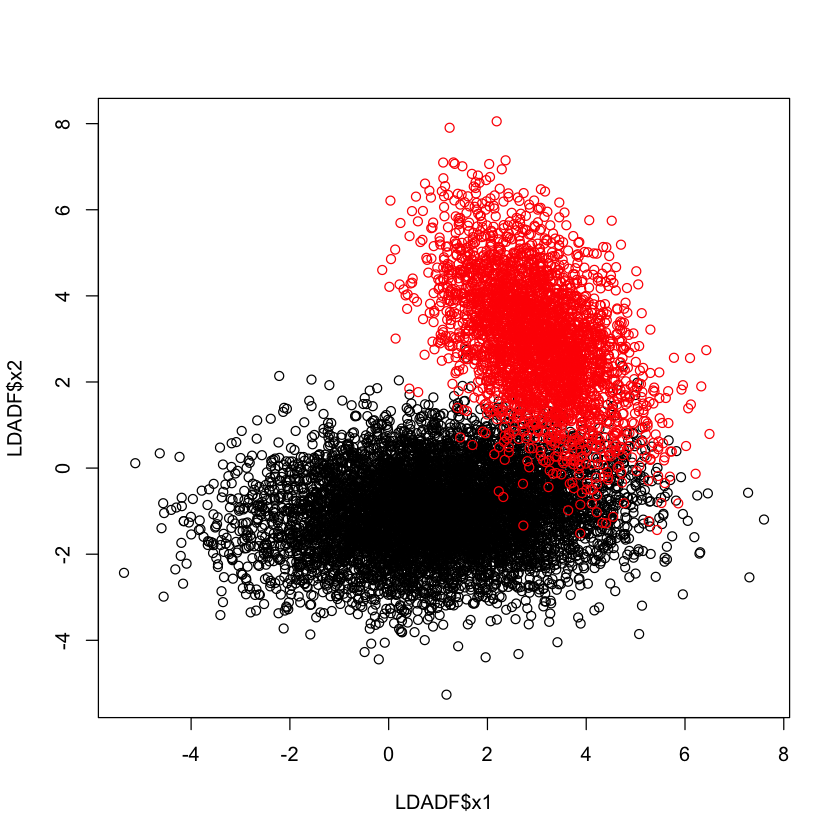

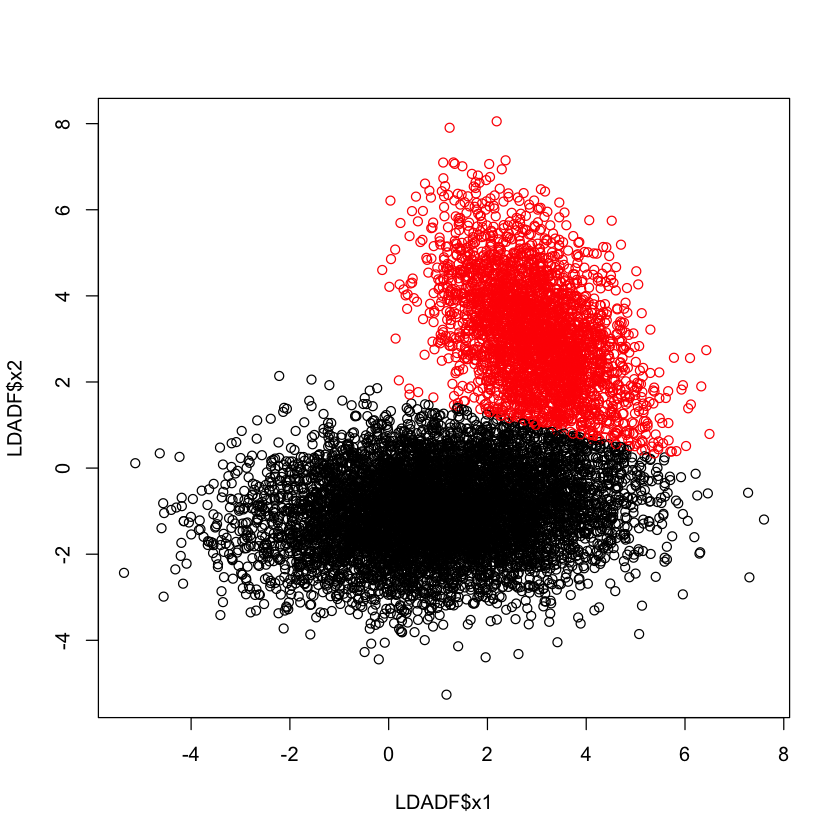

In [27]:
set.seed(1)
mvn<-function(mu0,cov0,n0){
  chol0=chol(cov0)
  xtemp=rbind(rnorm(n0),rnorm(n0))
  return(t(chol0)%*%xtemp+mu0)
}

#LDA:
n0=7000
y0=rep(0,n0)
cov0=rbind(c(3,.2),c(.2,1))
mu0=c(1,-1)
X0=mvn(mu0,cov0,n0)

n1=3000
y1=rep(1,n1)
cov1=rbind(c(1,-.7),c(-.7,2))
mu1=c(3,3)
X1=mvn(mu1,cov1,n1)
#note:
cov(X1[1,],X1[2,])
cov(X1[1,]-1,X1[2,])

response=c(y0,y1)
predictors=cbind(X0,X1)
LDADF=data.frame(t(rbind(response,predictors)))
names(LDADF)=c("y", "x1", "x2")

#basic LDA: 
muhat0=colMeans(LDADF[LDADF$y==0,])[-1]
muhat1=colMeans(LDADF[LDADF$y==1,])[-1]

sub.mu=function(indices,muhat){
  t(apply(LDADF[indices,-1],1, function(x)return(x-muhat)))
}
covHatOverall=cov(rbind(sub.mu(LDADF$y==0,muhat0), sub.mu(LDADF$y==1,muhat1)))
covHat0=cov(sub.mu(LDADF$y==0,muhat0))    
covHat1=cov(sub.mu(LDADF$y==1,muhat1))

p0hat=mean(LDADF$y==0)
p1hat=1-p0hat

#now we have all the esimates, so now we can make a prediction:
library(mvtnorm)
#LDA
post0=apply(LDADF[,-1], 1,function(x) dmvnorm(x, mean=muhat0, sigma = covHatOverall, log = F)) * p0hat
post1=apply(LDADF[,-1], 1,function(x) dmvnorm(x, mean=muhat1, sigma = covHatOverall, log = F)) * p1hat
classifiedAs1=post1>post0
plot(LDADF$x2~LDADF$x1, col=LDADF$y+1)
accuracy=sum(classifiedAs1==LDADF$y)/nrow(LDADF)
accuracy
print(covHatOverall)
plot(LDADF$x2~LDADF$x1, col=classifiedAs1+1)

[1] 0.9754

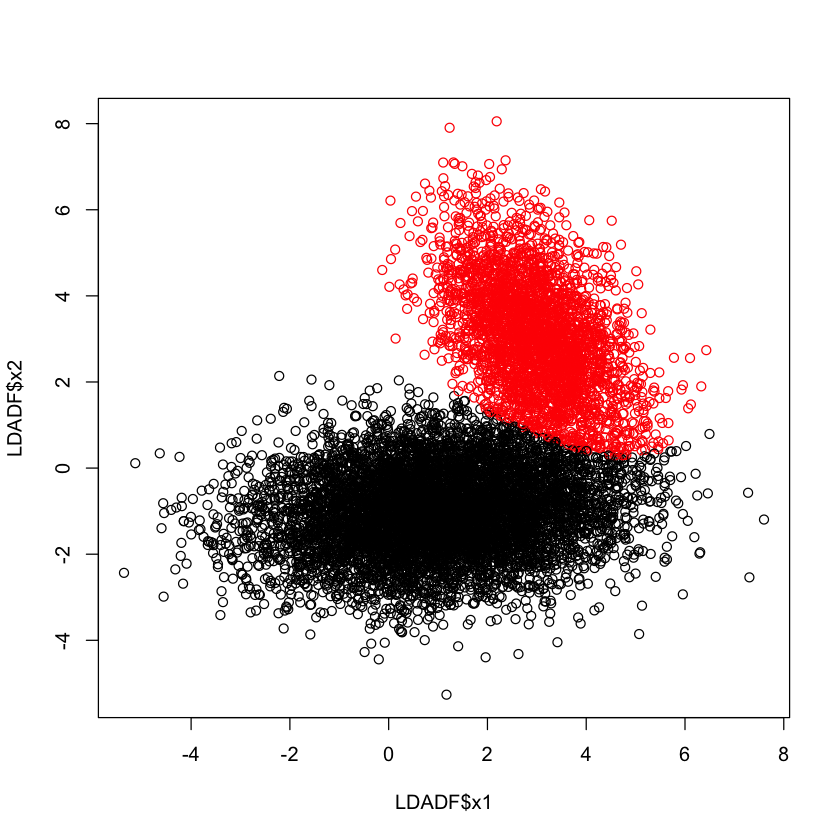

In [28]:
post0=apply(LDADF[,-1], 1,function(x) dmvnorm(x, mean=muhat0, sigma = covHat0, log = F)) * p0hat
post1=apply(LDADF[,-1], 1,function(x) dmvnorm(x, mean=muhat1, sigma = covHat1, log = F)) * p1hat
classifiedAs1=post1>post0
accuracy=sum(classifiedAs1==LDADF$y)/nrow(LDADF)
accuracy
plot(LDADF$x2~LDADF$x1, col=classifiedAs1+1)

[1] 0.9752

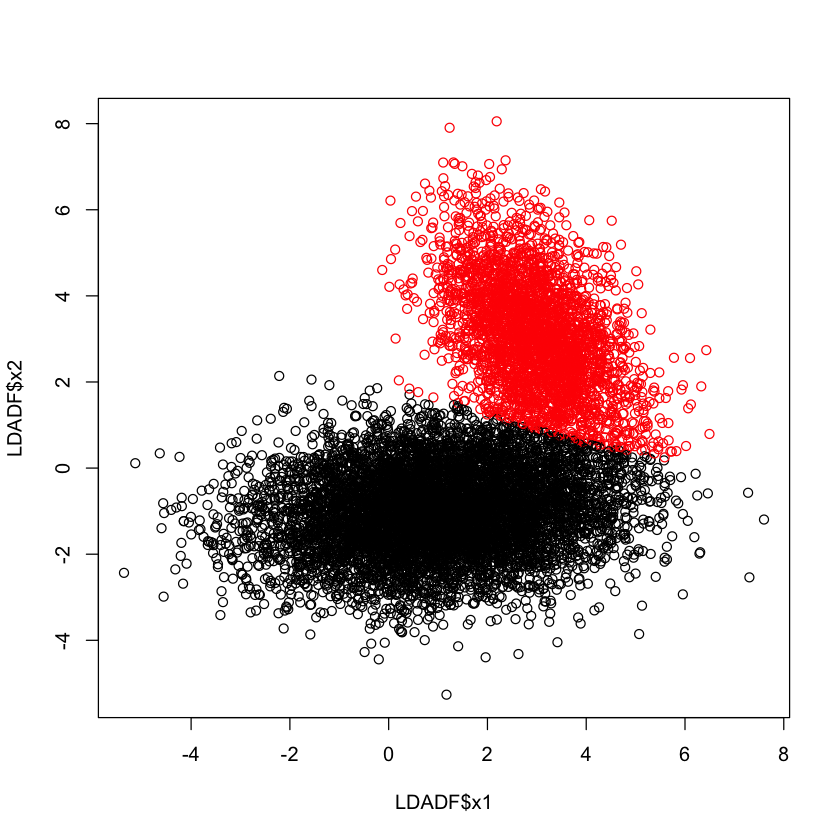

In [30]:
post0=apply(LDADF[,-1], 1,function(x) dmvnorm(x, mean=muhat0, sigma = .5* covHat0+ .5*covHatOverall, log = F)) * p0hat
post1=apply(LDADF[,-1], 1,function(x) dmvnorm(x, mean=muhat1, sigma = .5* covHat1+ .5*covHatOverall, log = F)) * p1hat
classifiedAs1=post1>post0
accuracy=sum(classifiedAs1==LDADF$y)/nrow(LDADF)
accuracy
plot(LDADF$x2~LDADF$x1, col=classifiedAs1+1)